# Progetto di Data and Web mining

Matteo Spanio, A.A. 2021/2022

# Feature engeneering

Dopo aver visionato i dati e stabilito una prima metrica di previsione il passo successivo è preparare i dati in modo da poterli dare in input a un modello predittivo più elaborato.

Un grosso problema del dataset che già abbiamo notato è la grande sparsità dei dati, su 90150 righe alcune colonne contano solo poche decine di dati inseriti, ma la libreria `sklearn` richiede in input matrici di dati senza campi vuoti, bisogna quindi decidere se eliminare le colonne o trovare un modo di inserire i dati mancanti.

In [1]:
from Zillow import data as zd

df = zd.load_dataset(2016)
df = df.set_index('parcelid')
df = df.drop('Unnamed: 0', axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90150 entries, 11016594 to 12566293
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   logerror                      90150 non-null  float64
 1   transactiondate               90150 non-null  object 
 2   airconditioningtypeid         28748 non-null  float64
 3   architecturalstyletypeid      260 non-null    float64
 4   basementsqft                  43 non-null     float64
 5   bathroomcnt                   90150 non-null  float64
 6   bedroomcnt                    90150 non-null  float64
 7   buildingclasstypeid           16 non-null     float64
 8   buildingqualitytypeid         57284 non-null  float64
 9   calculatedbathnbr             88974 non-null  float64
 10  decktypeid                    658 non-null    float64
 11  finishedfloor1squarefeet      6850 non-null   float64
 12  calculatedfinishedsquarefeet  89492 non-null  floa

Prima di compiere qualsiasi operazione potrebbe tornare utile creare una nuova feature in cui si vanno a contare per ogni riga il numero di feature mancanti, dal momento che stiamo cercando di stimare l'errore di previsione del modello di Zillow, la quantità di dati mancanti potrebbe essere un buono stimatore per quantificare gli errori.

In [2]:
df['nan_cnt'] = df.isna().sum(axis=1)

-- verde = Orange, blu = Los Angeles, giallo = Ventura

Procedendo in ordine per riga si effettuano le seguenti operazioni:
1. `transactiondate` è probabilmente importante, infatti la competizione chiede di effettuare le stime tenendo conto del mese di vendita della casa, però attualmente è in formato object, quindi si trasformerà il dato in tipo `datetime` e si estrapolerà il numero del mese in una nuova colonna;
2. `airconditioningtypeid` è una colonna abbastanza popolata e potrebbe contenere valori significativi, ma non contiene dati sulla contea di Orange, quindi, a meno che non si voglia costruire un modello differente per ogni contea siamo costretti a scartare la colonna;
3. `architecturalstyletypeid`, `basementsqft`, `buildingclasstypeid`, `decktypeid`, `storytypeid`, `typeconstructiontypeid`, `yardbuildingsqft26`, `yardbuildingsqft17` sono feature raccolte per pochissime case, una quantità insufficiente per poterci fare qualcosa;
4. `buildingqualitytypeid` è stato raccolto solo per le proprietà nella contea di Los Angeles, anche in questo caso va eliminata la colonna;
5. `calculatedbathnbr` presenta una distribuzione analoga a `bathroomcnt` con cui condivide anche la descrizione del campo, la colonna viene eliminata per ridondanza;
6. `finishedfloor1squarefeet`, `finishedsquarefeet13` e `finishedsquarefeet50` sono stati raccolti solo nella contea di Orange;
7. `finishedsquarefeet12` ha una fortissima correlazione con `calculatedfinishedsquarefeet`, che però contiene meno valori nulli, quindi si elimina anche `finishedsquarefeet12` dal dataframe;
8. `finishedsquarefeet15` ha troppi valori nulli per poter essere preso in considerazione;
9. `finishedsquarefeet6` è stato raccolto solo nella contea di Ventura;
10. `fireplacecnt` non è stato raccolto nella contea di Los Angeles;
11. `fullbathcnt` ha una forte correlazione con `bathroomcnt`;
12. `garagecarcnt` e `garagetotalsqft` non sono stati raccolti nella contea di Los Angeles;
13. `hashottuborspa` e `heatingorsystemtypeid` non contengono valori per la contea di Orange;
14. `latitude` e `longitude` vanno divisi per 10e5 per essere trasformati in vere coordinate;
15. `poolcnt` è registrato solo per 17876 righe, questi record hanno tutti valore 1, tutti gli altri sono `nan`, dal momento che la descrizione fornita dice:
    > Number of pools on the lot (if any)
    
    questo ci fa supporre che in presenza di case con 0 piscine questo valore non sia stato registrato, una soluzione è porre tutti i nan a 0 oppure eliminare la colonna, in quanto si ritiene verosimile che circa l'80% delle proprietà non abbia una piscina si imporranno i nan = 0;
16. `poolsizesum` è un dato troppo esiguo per essere tenuto in considerazione;
17. `roomcnt` in tutta la contea di Los Angeles ha valore assegnato pari a 0;
18. `threequarterbathnbr` è già stato preso in considerazione in `bathroomcnt`;
19. `unitcnt` è abbastanza numeroso e i valori sono tutti numeri tranne una numerosa parte di nan
    >  Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...)
    
    supponiamo che i valori nan siano stati inseriti al posto delle proprietà in cui non vi siano edifici;
20. 

In [3]:
import pandas as pd
from Zillow.data import droplist

df['transactiondate'] = pd.to_datetime(df['transactiondate'], format='%Y-%m-%d')
df['transactionmonth'] = df.transactiondate.dt.month

df['latitude']  = df['latitude']  / 10e5
df['longitude'] = df['longitude'] / 10e5

df['poolcnt'] = df['poolcnt'].fillna(0.)
df['unitcnt'] = df['unitcnt'].fillna(0.)

df = df.drop(droplist, axis=1)

In [4]:
diz = { # TODO: spostare in libreria
    31 : 'Commercial/Office/Residential Mixed Used',
    46 : 'Multi-Story Store',
    47 : 'Store/Office (Mixed Use)',
    246: 'Duplex (2 Units, Any Combination)',
    247: 'Triplex (3 Units, Any Combination)',
    248: 'Quadruplex (4 Units, Any Combination)',
    260: 'Residential General',
    261: 'Single Family Residential',
    262: 'Rural Residence',
    263: 'Mobile Home',
    264: 'Townhouse',
    265: 'Cluster Home',
    266: 'Condominium',
    267: 'Cooperative',
    268: 'Row House',
    269: 'Planned Unit Development',
    270: 'Residential Common Area',
    271: 'Timeshare',
    273: 'Bungalow',
    274: 'Zero Lot Line',
    275: 'Manufactured, Modular, Prefabricated Homes',
    276: 'Patio Home',
    279: 'Inferred Single Family Residential',
    290: 'Vacant Land - General',
    291: 'Residential Vacant Land',
}

df['land_use_for'] = df['propertylandusetypeid'].replace(diz)

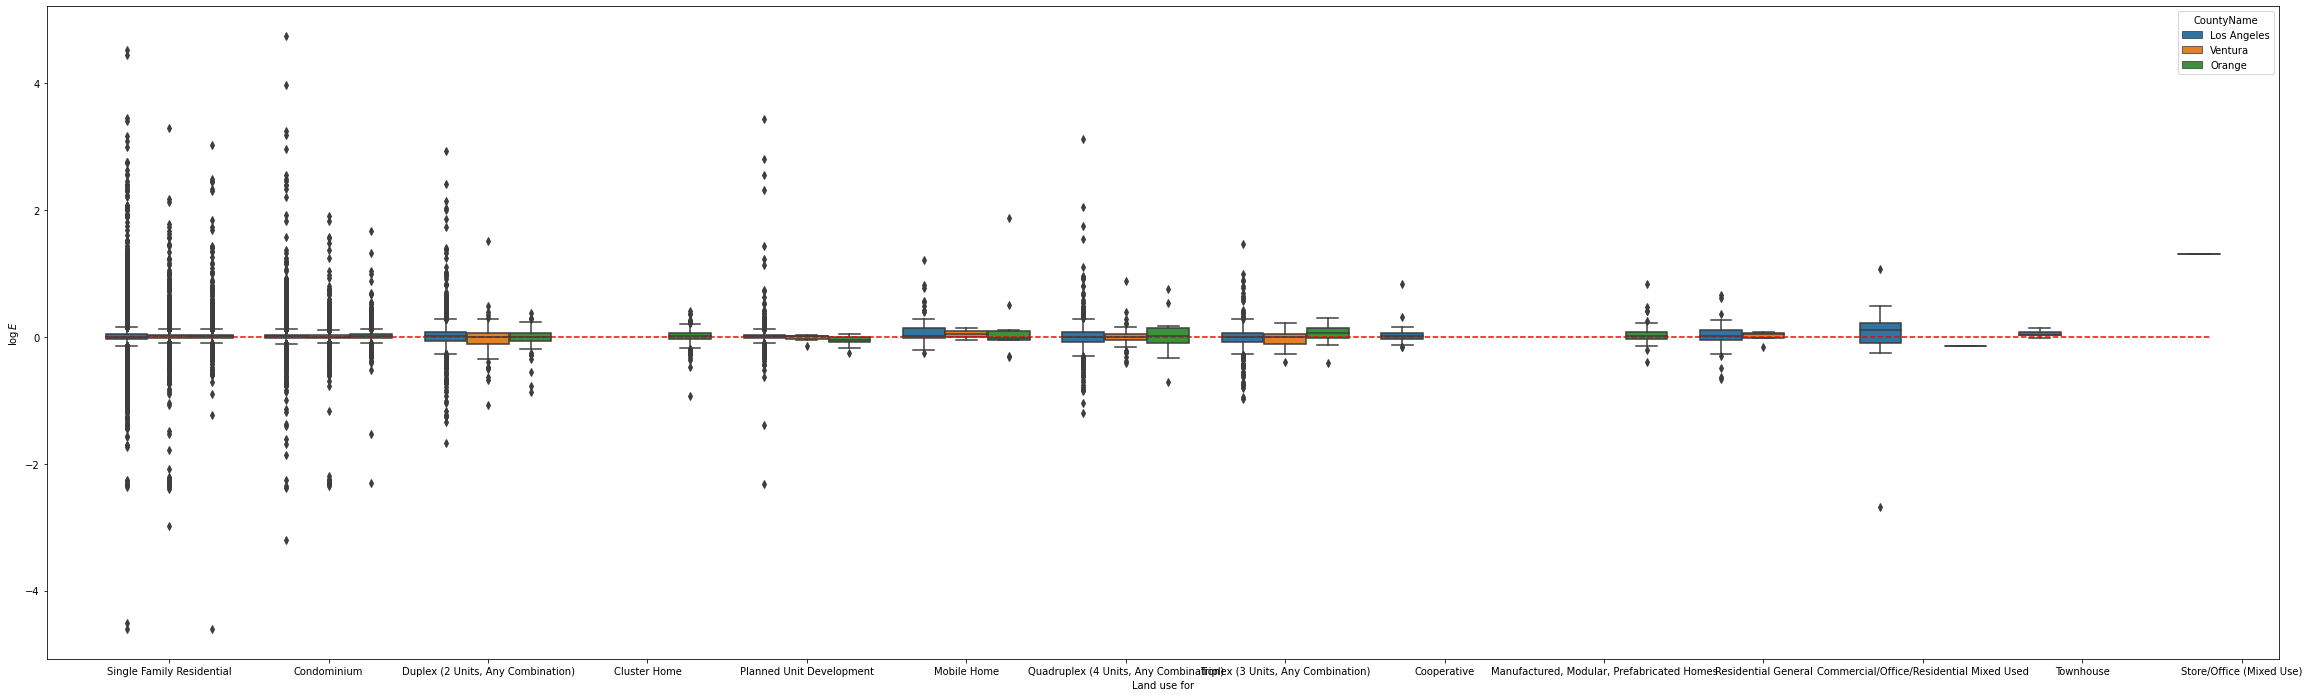

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(40,12))
sns.boxplot(data=df, x="land_use_for", y='logerror', hue="CountyName", ax=ax)
#ax.set_ylim(-1, 1)
ax.set_xlabel('Land use for')
ax.set_ylabel(r'$\log E$')
ax.hlines(0., xmin=-0.4, xmax=12.8, colors='red', linestyles='dashed');